#Lab 5: Recunoasterea faciala folosind vectori si valori proprii.

**Introducere:**  În 1991, Turk și Pentland au propus o abordare a recunoașterii faciale care se bazează pe concepte de reducere a dimensionalității și algebră liniară.

Tehnica folosită pentru reducerea dimensionalității poartă numele de **Analiza Componentelor Principale** (în engl. Principal Component Analysis, PCA).

Această metodă presupune calcularea componentelor principale utilizând valori și vectori proprii, apoi folosirea acestora pentru a efectua o schimbare de bază asupra datelor — de multe ori păstrând doar primele componente principale și ignorându-le pe celelalte.


#Descrierea aplicatiei


#### Biblioteci utilizate in Python

In [6]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 7.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [28]:
import numpy as np
import numpy.matlib
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

#### Definim functia` plot_faces` pentru a afisa primele 30 de poze din setul de date.

In [29]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(64, 64), cmap='gray')
    plt.show()

### Descriere baza de date

Baza de date utilizata cuprinde pozele a 40 de persoane etichetate cu un numar, iar fiecare persoana are cate 10 poze. Setul de date se gaseste in fisierul  `face_data.csv.`

Vom utiliza setul de date in format matriceal de dimensiune $400 × 4097$:
* o linie reprezinta o imagine vectorizata $→ 400$ de imagini.
* fiecare imagine are dimensiunea $64 × 64 = 4096$ de valori.
* ultima coloana reprezinta eticheta pozei de pe linia $i$.

**Ce este o imagine vectorizata?** Transformarea unei imagini bidimensionale
$n \times n$ într-un vector de dimensione $n^2\times 1$ plasând pixelii imaginii unul sub altul, pe o singură coloană.

In [9]:
df = pd.read_csv('face_data.csv')
#pandas.DataFrame.nunique finds the unique elements(lines) of a dataset
df['target'].nunique()
#Print dataframe
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.400826,0.495868,0.570248,0.632231,0.648760,0.640496,0.661157,0.636364,0.665289,0.698347,...,0.396694,0.264463,0.099174,0.181818,0.243802,0.247934,0.161157,0.157025,0.136364,39
396,0.367769,0.367769,0.351240,0.301653,0.247934,0.247934,0.367769,0.512397,0.574380,0.628099,...,0.334711,0.289256,0.285124,0.338843,0.404959,0.458678,0.487603,0.512397,0.549587,39
397,0.500000,0.533058,0.607438,0.628099,0.657025,0.632231,0.657025,0.669422,0.673554,0.702479,...,0.148760,0.152893,0.161157,0.161157,0.173554,0.157025,0.177686,0.148760,0.190083,39
398,0.214876,0.219008,0.219008,0.223140,0.210744,0.202479,0.276859,0.400826,0.487603,0.549587,...,0.392562,0.367769,0.409091,0.479339,0.524793,0.545455,0.574380,0.590909,0.603306,39


Definim urmatoarele variabile:
* $X \in \mathbb{R}^{400 \times 4096}$ - matricea cu tot setul de date
* $y \in \mathbb{R}^{400}$             - vectorul de etichete

In [10]:
# Drop the column 'target' from dataset in order to save just the images in X.
X = df.drop('target', axis=1)
Y = df['target']
print('X shape is: ',X.values.shape)
print('Y shape is: ',Y.values.shape)

X shape is:  (400, 4096)
Y shape is:  (400,)


#### Vizualizarea setului de date.

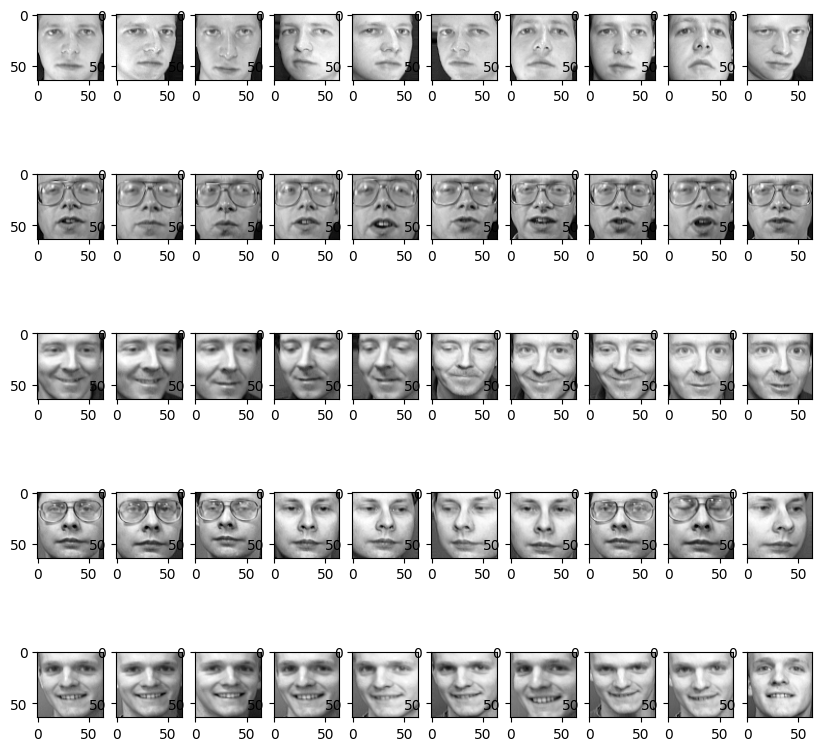

In [11]:
plot_faces(X)

#### Împarte setul de date în date de antrenare și testare.

Vom folosi 75% din date pentru faza de antrenare.
Imaginile selectate sunt alese aleator, nu într-o ordine specifică.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print('X_train shape is: ',X_train.values.shape)
print('Y_train shape is: ',Y_train.values.shape)
print('X_test shape is: ',X_test.values.shape)
print('Y_test shape is: ',Y_test.values.shape)

X_train shape is:  (300, 4096)
Y_train shape is:  (300,)
X_test shape is:  (100, 4096)
Y_test shape is:  (100,)


#### Vizualizare set de date de antrenare.

Observati ca imaginile sunt aranjate aleator, iar in setul de antrenare avem 300 de imagini.

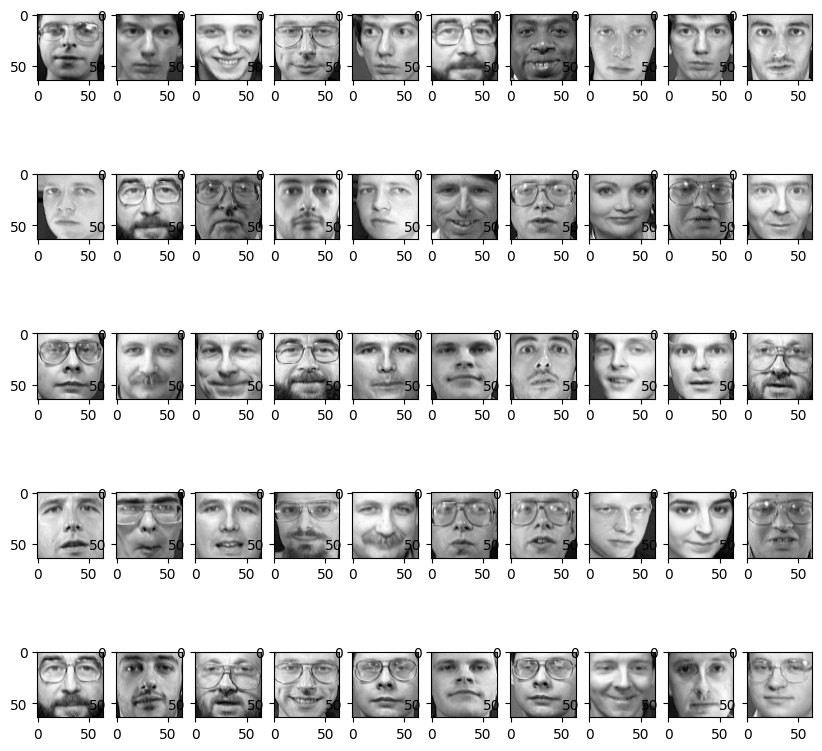

In [13]:
plot_faces(X_train)

## Faza de antrenare: Construirea Eigenface-urilor

#### "The average face"

Primul pas în construirea Eigenface-urilor este să centrăm datele elimnând fața medie $\mu$ (in engl. *average face*). Astfel, pentru matricea $X \in \mathbb{R}^{m \times n}$ de mai sus se calculeaza media aritmetică pentru fiecare coloană:

$$
\begin{aligned}
 \mu_j=\frac{1}{m} \sum_{i=1}^m X_{i,j} \quad \forall j = \{1, \ldots, n \}
\end{aligned}
$$

Imaginile au dimensiunea $64 \times 64$, deci rezultă 4096 valori medii, câte una pentru fiecare coordonată.

mean shape:  (4096,)


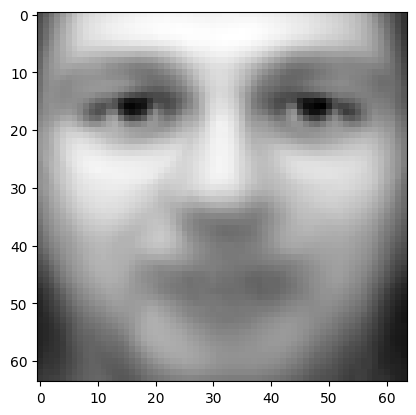

In [14]:
mean=X_train.mean(axis=0)
print('mean shape: ',mean.shape)
plt.imshow(np.array(mean).reshape(64, 64), cmap='gray')
plt.show()

#### Centram datele extragand media
Setul de date de antrenare centrat il notam cu $\hat{X} \in \mathbb{R}^{m \times n} $ si se obtine astfel:
$$
\begin{aligned}
& \hat{X}_{i,j} =X_{i,j} \text -\mu_j \quad \forall i=1: m,\, j= 1:n
\end{aligned}
$$

In [15]:
# np.matlib.repmat duplicates the mean, which is a line of size 4096, 300 times
# to match the size of X_train
X_train_centered = X_train.values - np.matlib.repmat(mean,300,1)
print('X_train_centered shape: ',X_train_centered.shape)

X_train_centered shape:  (300, 4096)


#### Calcularea matricei de covarianta


Mai departe, calculăm matricea de covarianta multiplicând $\hat{X}$ cu $\hat{X}^T$. Utilizăm aceasta înmultire și nu $\hat{X}^T \hat{X}$, pentru că dimensiunea matricei rezultate este mai mica in primul caz, lucru dezirabil pentru următorul pas și anume calcularea vectorilor și valorilor proprii:

$$
L=\hat{X} \hat{X}^T \succcurlyeq 0 \quad \in \mathbb{R}^{m \times m}
$$


Dorim să aflăm vectorii și valorile proprii pentru $L$ :

$$
\hat{X} \hat{X}^T \nu_i=\lambda_i \nu_i \quad  \Leftrightarrow \quad \hat{X}^T \hat{X} \hat{X}^T \nu_i=\lambda_i \hat{X}^T \nu_i \quad \Leftrightarrow \quad L^{\prime} u_i=\lambda_i u_i \quad (1)
$$

unde

$$
u_i=\hat{X}^T \nu_i .
$$


**Observăm ca $L^{\prime}$ și $L$ au aceleași valori proprii** și ca vectori proprii sunt asociati prin intermediul equației (1). Prin urmare, cei $m$ vectori și valori proprii ale lui $L$ sunt și primele $m$ cele mai mari valori proprii ale lui $L^{\prime}$.

Acum calculăm **vectorul propriu și valorile proprii** ale acestei matrice de covarianță reduse $L$ și le mapăm în $L^{\prime}$ folosind formula (1):

$$
\begin{aligned}
& {[V, \lambda]=\operatorname{eig}(L)} \\
& U=\hat{X}^T * V \in R^{4096 \times 300}
\end{aligned}
$$

unde $\lambda \in \mathbb{R}^{300}$ si $V \in \mathbb{R}^{300 \times 300}$.

In [16]:
# np.matmul computes the matrix multiplication
# np.transpose computes the transpose of the matrix
L=np.matmul(X_train_centered,np.transpose(X_train_centered))
# np.linalg.eig computes the eigenvalues as an array and the eigenvactors as a matrix
[eig_values,eig_vectors] =  np.linalg.eig(L)
print('eig_values shape: ',eig_values.shape)
print('eig_vectors shape: ',eig_vectors.shape)

eig_values shape:  (300,)
eig_vectors shape:  (300, 300)


Sortează valorile proprii în ordine descrescătoare, apoi rearanjează vectorii proprii în funcție de noua ordine a valorilor proprii.


In [17]:
keys=eig_values.copy().argsort()[::-1]
eig_vectors=[eig_vectors[i] for i in keys]
eig_vectors = np.array(eig_vectors)

#### Reducerea dimensionala. Gasirea Eigenfețele

Calculăm suma cumulativă pentru fiecare valoare proprie. Aceasta arată ce procent din totalul valorilor proprii este acoperit de primele $n$ valori proprii.

Formula procentajului pentru valoarea proprie de rang $j$ este:

$$
\text{Procent informatie} (j) =
\frac{\displaystyle \sum_{i=1}^{j} \lambda_i}
     {\displaystyle \sum_{i=1}^{m} \lambda_i}
$$

unde $\lambda_i$ reprezintă valorile proprii sortate descrescător, iar $m=300$ este numărul total de valori proprii.


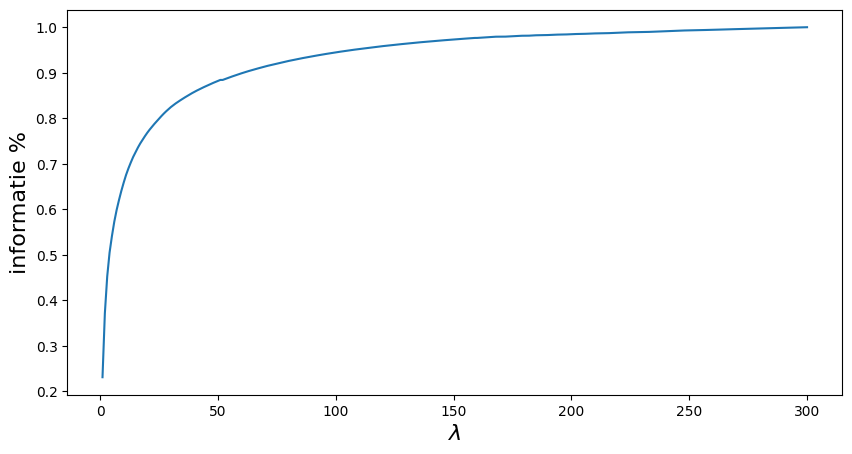

In [18]:
# eig_values_cumsum[-1] means the last element of the cumulative sum, which is in fact
# the sum of all eigenvalues
eig_values_cumsum=np.cumsum(eig_values)
eig_cumsum_percent = eig_values_cumsum / eig_values_cumsum[-1]
plt.figure(figsize=(10,5))
plt.plot(range(1,301), eig_cumsum_percent)
plt.xlabel("$\lambda$", fontsize=16)
plt.ylabel("informatie %", fontsize=16)
plt.show()

Primele `number_of_eig_values` valori proprii sunt selectate. Numărul valorilor proprii selectate determină procentul de informație care este păstrat.

In [19]:
threshold = 0.95
number_of_eig_values = np.argmax(eig_cumsum_percent >= threshold) + 1

eig_vectors_selected = eig_vectors[0:number_of_eig_values]
print('eig_vectors_selected shape: ',eig_vectors_selected.shape)

eig_vectors_selected shape:  (107, 300)


#### Eigenfețele sunt calculate prin înmulțirea matricei X_train_centered cu matricea eig_vectors_selected.

Observatie:

*  aceste eigenfete $U$ sunt vectorii proprii pentru matricea de covarainta mai mare $L' = X^T X$

*  acestea sunt noile directii pe care noi proiectam
*  vectorii proprii ale unei matrice simetrice sunt ortogonali

In [20]:
Eigenfaces=np.matmul(np.transpose(X_train_centered), np.transpose(eig_vectors_selected))
print('Eigenfaces shape: ',Eigenfaces.shape)

Eigenfaces shape:  (4096, 107)


### Vizualizarea Eigenfețele

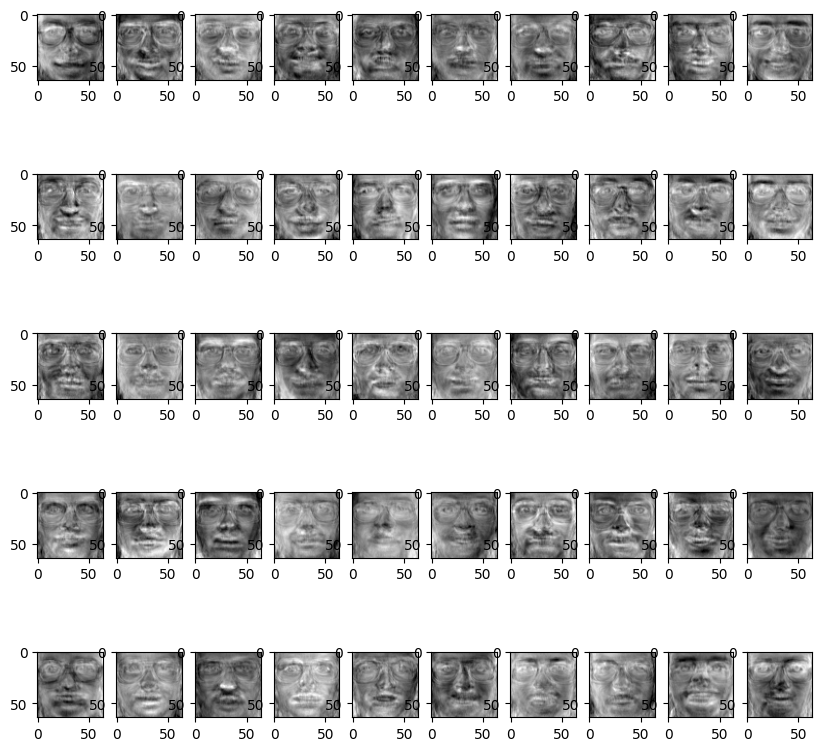

In [21]:
plot_faces(np.transpose(Eigenfaces))

#### Calcularea matricei de Proiectii.

Amintim reprezentarea standard a unui vector $y \in \mathbb{R}^n$
$$
y = \sum_{i=1}^{n}y_i *e_i =\sum_{i=1}^{n} (e_i^Ty) *e_i, \, \text{ unde } e_i \text{este vectorul din baza ortonormata}
$$
Prin urmare o imagine $\hat{X}_i$ este reprezentata ca o combinație liniară între eigenface-urile găsite (noile directii) și proiecțiile imaginilor pe acest nou spatiu:

$$
\hat{X}_i^T=X_i^T-\mu =\sum_j^m P_{j, i} * U_j,
$$

unde $P$ este matricea de proiectie $U^T \hat{X}^T $.

Astfel o imagine din setul de antrenare, este memorata sub forma unui vector de coeficienti, i.e pentru imaginea $i$ coeficientii asociati acesteia sunt coloana $i$ din matricea $P$.

In [22]:
ProjectedImages =   Eigenfaces.T @  X_train_centered.T
print('ProjectedImages shape: ',ProjectedImages.shape)

ProjectedImages shape:  (107, 300)


## Faza de testare: Identificarea persoanei

Luăm o imagine de test din baza noastra de date pe care vrem să o comparăm cu imaginile din baza de antrenare și să vedem care din acele imagini se potrivește cu imaginea data. Pentru o cautare eficienta vom folosi doar matricea de proiectii $P$

Pentru aceasta, memorăm intr-un vector de $1 \times 4096$ imaginea extrasa din setul de testare si o vom denumi `testImg`.

**Imaginea test este centrată** prin scăderea din ea a vectorului medie $\mu$ care a fost calculat în faza de antrenare.

Observație: imaginea testată nu este inclusă în setul de antrenament.

X_test shape:  (100, 4096)
The chosen image is:


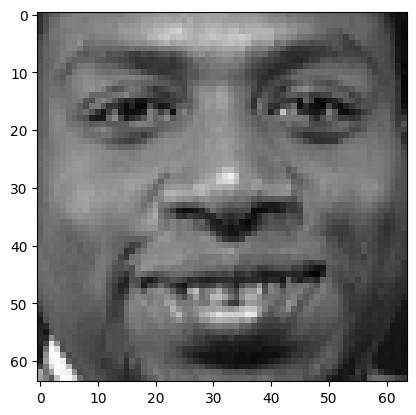

In [ ]:
random_index = random.randint(0,99)
X_test_centered = X_test.values[random_index] - mean

print('X_test shape: ',X_test.values.shape)
plt.imshow(np.array(X_test)[random_index].reshape(64, 64)g, cmap='gray')
print('The chosen image is:')


 Calculam vectorul de coeficienti ai proiectiei ca o combinație liniară dintre "testImg" şi toate eigenface-urile:

$$
P_{\text {new }}=U^T *(\text { testImg }- \text { mean })
$$

In [24]:
X_test_projection = Eigenfaces.T @ X_test_centered.T
print('X_test_projection shape: ',X_test_projection.shape)

X_test_projection shape:  (107,)


Pentru a vedea daca noua imagine se gaseste în baza de date, calculăm distanța dintre imaginea test și cele din baza de antrenare, scăzand coeficientii. În cele din urma, imaginea cea mai asemanatoare din baza de date, corespunde celei mai mici distanțe:

$$
I=\arg \min _{i=1: m}\left\|\mathrm{P}(:, i)-\mathrm{P}_{\text {new }}\right\|
$$



In [25]:
Euc_dist = ProjectedImages - np.transpose(np.matlib.repmat(X_test_projection,300,1))
Euc_dist = np.square(np.linalg.norm(Euc_dist,axis=0))
print('Euc_dist shape: ',Euc_dist.shape)

Euc_dist shape:  (300,)


Indicele distanței minime este extras. Acest indice este un număr natural între 0 și 300 (adică 75% din întregul set de date).

In [26]:
minimum_index = np.argmin(Euc_dist)

#### Vizualizarea cautarii
Eticheta gasita mai sus se compara cu eticheta adevarata.


Tested person was labeled:  21
Found person was labeled:  21


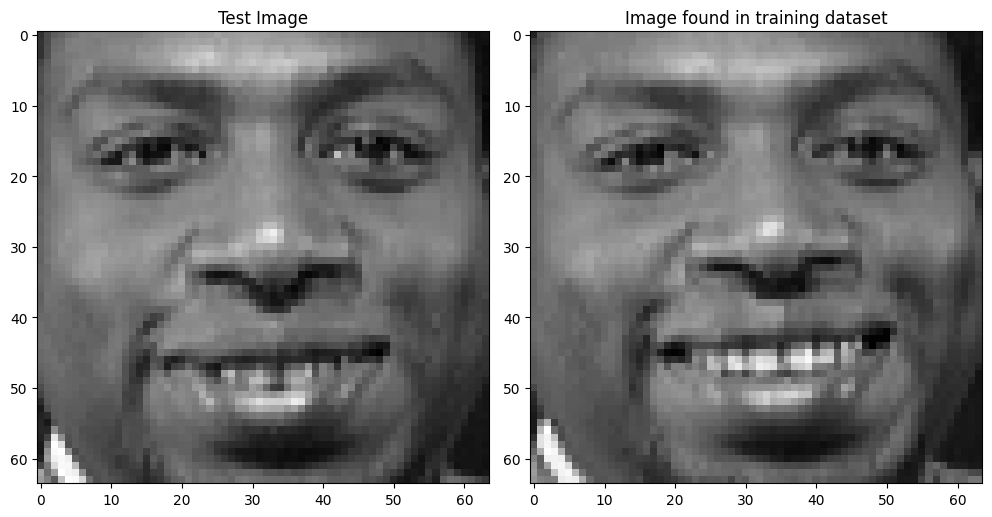

In [27]:
print('Tested person was labeled: ',Y_test.values[random_index])
print('Found person was labeled: ',Y_train.values[minimum_index])
f, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.array(X_test)[random_index].reshape(64, 64), cmap='gray')
ax[1].imshow(np.array(X_train)[minimum_index].reshape(64, 64), cmap='gray')
ax[0].set_title('Test Image')
ax[1].set_title('Image found in training dataset')
f.tight_layout(pad=1.0)

Pentru o noua testare se ruleaza din nou de la fazele de testare

### Avantaje/ Dezavantaje
* PCA este o tehnică eficientă atunci când imaginile sunt realizate în același context.
* Nu funcționează bine atunci când imaginile de test diferă mult față de cele din setul de antrenare.
* Merită utilizată pe seturi de date omogene, în care imaginile nu diferă foarte mult între ele (de exemplu: aceeași poziție, aceeași lumină, aceleași condiții de captură).
* Oferă performanțe numerice bune, deoarece operația EIG (eigendecompoziția) este executată o singură dată.

### Bibliografie
M. Turk, A. Pentland. ”Eigenfaces for Recognition”. Journal of Cognitive Neuro-
science. Vol 3, No. 1. 71-86, 1991